In [2]:
# All imports
from pathlib import Path
import warnings
from typing import Any, Tuple, Union
import cv2
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

Didn't really want to figure out which parts of your code load the data, so i quickly made my own. 

In [3]:
BASE: Path = Path("bleaching_data_RS")
IMG_DIR: Path = BASE / "images"
MASKS_BLEACHED_DIR: Path = BASE / "masks_bleached"
MASKS_UNBLEACHED_DIR: Path = BASE / "masks_non_bleached"


def find_mask_triple(img_path: Path) -> Union[Tuple[Path, Any, Any], Tuple[Path, None, None]]:
    """
    Group the original and mask image files based on their stem.
    The stem is the original file name without the file extension. 
    As this is the same for all 3 images, it will select them all. 

    Args:
        img_path (Path): file path of an image in the "images" folder

    Returns:
        tuple[Path, Any, Any] | tuple[Path, None, None]: tuple of file paths for all equal images (original + 2 masks)
    """
    image_stem = img_path.stem 

    bleached_path = MASKS_BLEACHED_DIR / f"{image_stem}_bleached.png"
    unbleached_path = MASKS_UNBLEACHED_DIR / f"{image_stem}_non_bleached.png"
    if bleached_path.exists() and unbleached_path.exists(): # Check that all 3 versions of the image are there, and group them
        return img_path, bleached_path, unbleached_path
    return img_path, None, None

# Build the dataset
triple: list[Any] = []
for img_path in IMG_DIR.glob("*.jpg"):
    img_path, bleached_path, non_bleached_path = find_mask_triple(img_path)
    if bleached_path is None or non_bleached_path is None:  # Warning if there is a missing mask
        print(f"[WARN] Missing masks for {img_path.name}")
        continue
    triple.append((img_path, bleached_path, non_bleached_path))

print(f"Found {len(triple)} image/mask triples.")

Found 658 image/mask triples.


Underwater images typically have a blue/green cast. This could be an issue for a model, as it would get biased to this color scheme. <br>
This is fixed by creating a gray world balance, where the average color of all color channels is achromatic (so r = b = g). <br>
Merging these channels then makes it so that the average color of all pixels is gray. <br>
As shown in the side by side comparison, the green/yellow tint is removed from the image. <br>
The parts that are white IRL appear to be a red/purple-ish tint (red is boosted to make up for the excess blue/green tint). For now this may look weird, but eventually RGB colors will not matter anymore so this is not a problem.<br>

idx=11 is a good example where tint is removed without altering the image much more. idx=12 shows the red tint that is explained above.

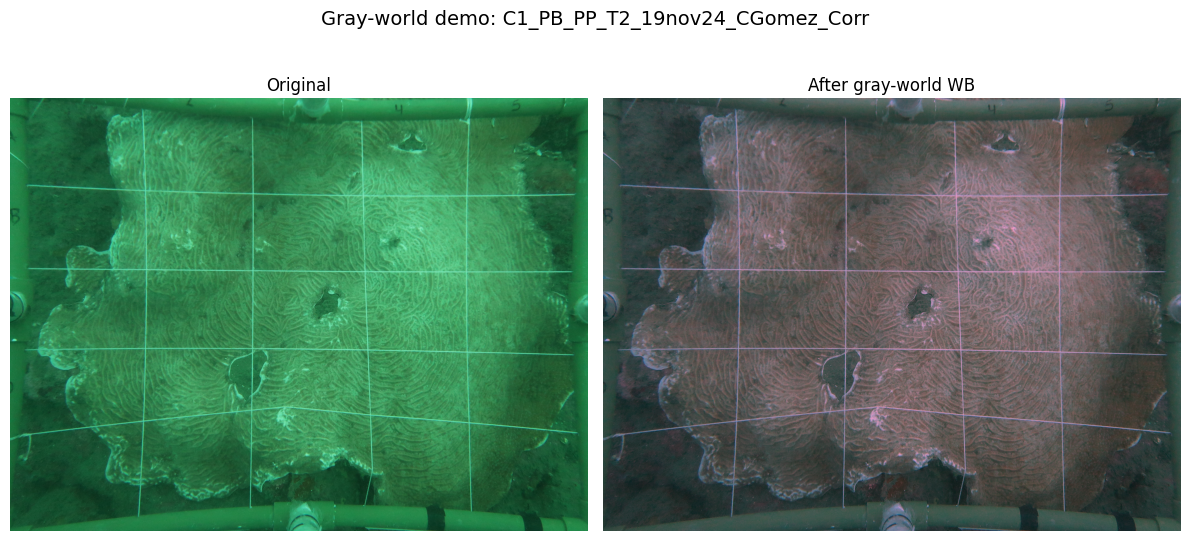

In [6]:
def gray_world_wb(bgr: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """
    Transform any (colored) image into a gray-world WB image.

    Args:
        bgr (NDArray[np.uint8]): Array that represents all three color channels, combined
        This is before the gray-world wb transformation
    Returns:
        NDArray[np.uint8]: Array that represents all three color channels, combined.
        This is after the gray-world wb transforamtion
    """
    b, g, r = cv2.split(bgr.astype(np.float32)) # split image into color channels.
    mb, mg, mr = b.mean(), g.mean(), r.mean()   # Calculate mean value of each color channel.
    m = (mb + mg + mr) / 3.0    # Calculate global average.
    b *= m / (mb + 1e-6)    # Adjust each of the color channels.
    g *= m / (mg + 1e-6)
    r *= m / (mr + 1e-6)
    out = cv2.merge([b, g, r])  # Merge the channels back into one
    return np.clip(out, 0, 255).astype(np.uint8)


def get_bgr_path_by_idx_or_name(idx_or_name: Union[int, str]) -> Path:
    """
    Function that takes either the index or the name of an image, and gives the file path.

    Args:
        idx_or_name (int | str): Index or name of the image you want to view.

    Raises:
        ValueError: Gets raised when filename is not in dataset.

    Returns:
        Path: Path to the image you want to view.
    """
    # Either input the index or the name of the original file
    if type(idx_or_name) == int:
        img_path, _, _ = triple[idx_or_name] # Select original image path
    elif type(idx_or_name) == str:
        stem = Path(idx_or_name).stem.lower()

        # find match in triple
        for img_path, _, _ in triple:
            if img_path.stem.lower() == stem:
                break
        else:
            raise ValueError(f"No image with stem '{stem}' found in dataset.")
    else:
        raise TypeError("The filename or an index value should be given.")
    return img_path


def demo_gray_world(idx_or_name: Union[int, str] = 0) -> None:
    """
    Gives a side by side comparison of the gray-world white balance that is defined above.

    Args:
        idx (int | str): Index or name of the image you want to view.
    """
    img_path = get_bgr_path_by_idx_or_name(idx_or_name)
    
    img_bgr = cv2.imread(img_path)  

    # Apply gray-world white balance
    corrected_bgr = gray_world_wb(img_bgr) 

    # Convert BGR->RGB for matplotlib
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    corrected_rgb = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2RGB) 

    # Plot side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(img_rgb)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(corrected_rgb)
    axs[1].set_title("After gray-world WB")
    axs[1].axis("off")

    plt.suptitle(f"Gray-world demo: {img_path.stem}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Try it on some image
demo_gray_world(idx_or_name="C1_PB_PP_T2_19nov24_CGomez_Corr.JPG")

For a selected image, the image is converted into gray-world wb. Then that is split into LAB.  
LAB is a way to represent color in terms of lightness (L), and two color components (a and b).  
We will use the lightness component to show whiteness.  
  
CLAHE = Contrast Limited Adaptive Histogram Equalization
Histogram equalization (HE) equalizes the color/light intensities across the entire image. Think of a histogram with the color/light intensities on the x axis. This could over- or under-brighten certain parts if the lighting is uneven in the image.  
That's why adaptive HE is done, where the image is split into an 8x8 grid. Each gridtile is equalized locally, and then stichted together.  
However, if you now have a tile that is very uniform (e.g. all pixels have a value of 50), AHE wants to stretch its very limited value range to the whole 0-255. If there is a little noise, this gets expanded into a big change.  
CLAHE introduces a cliplimit for the histogram bins. If an intensity value gets clipped, the excess is redistributed among the other bins. This way no single value has a giant peak while the others have none.  
  
After this, the adjusted lightness is added back with the color components.

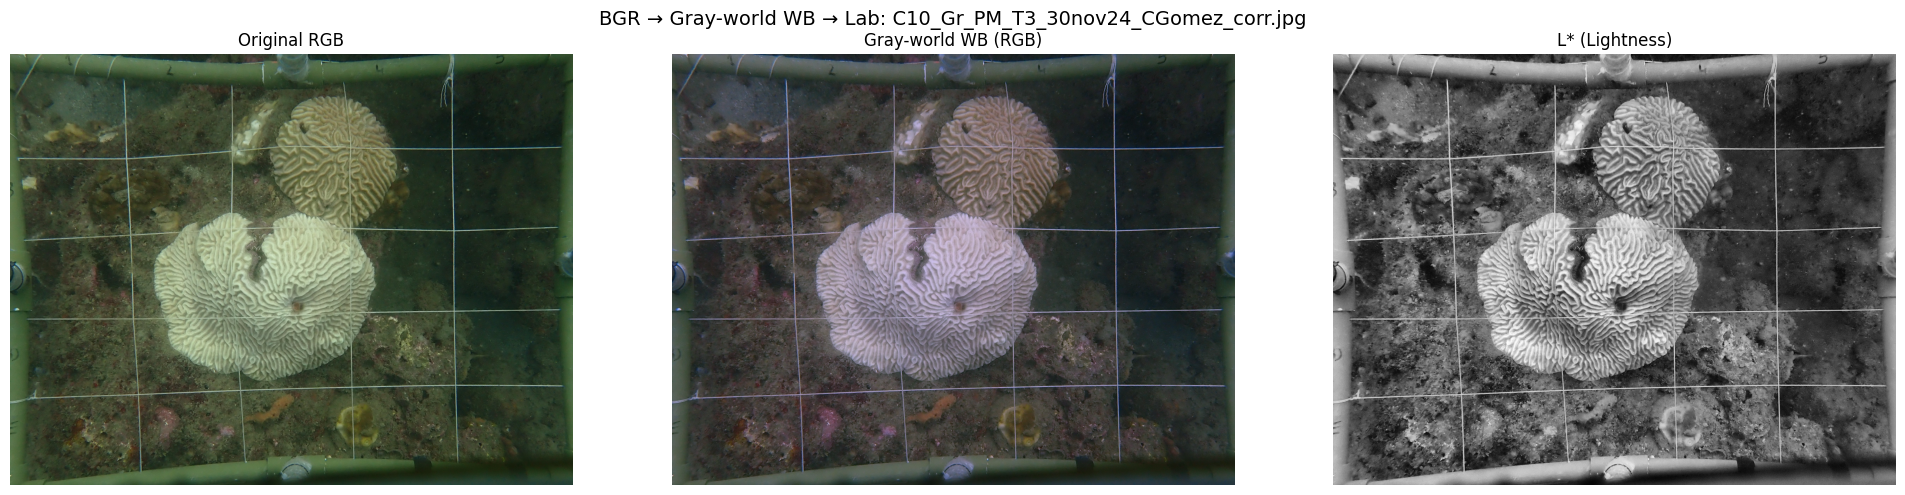

In [7]:
def bgr_to_lab(bgr: npt.NDArray[np.uint8]) -> npt.NDArray[np.uint8]:
    """
    Takes an image in BGR format, converts to LAB, applies CLAHE to L, an merges the equalized L with the original color components.

    Args:
        bgr (NDArray[np.uint8]): 3D matrix with three color channels. 

    Returns:
        NDArray[np.uint8]: 3D matrix with lightness and two color channels.
    """
    bgr = gray_world_wb(bgr) 
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB) # Convert BGR to LAB
    L, a, b = cv2.split(lab)    # Allows lightness to be used on its own.

    # Local contrast equalization with clipping to avoid noise amplification
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L_eq = clahe.apply(L)

    lab_eq = cv2.merge([L_eq, a, b])
    return lab_eq


def demo_bgr_to_lab_with_wb(idx_or_name: Union[int, str]=0) -> None:
    """
    Show Original RGB, Gray-world WB RGB, and Lab channels (from WB image).

    Args:
        idx_or_name: index (int) or filename/stem (str)
    """
    # Get image path
    img_path = get_bgr_path_by_idx_or_name(idx_or_name)

    # Get original image
    img_bgr = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Get gray-world white balance image
    gw_bgr = gray_world_wb(img_bgr)
    gw_rgb = cv2.cvtColor(gw_bgr, cv2.COLOR_BGR2RGB)

    # Get LAB image
    gw_lab = bgr_to_lab(img_bgr)
    L, a, b = cv2.split(gw_lab)

    # Plot original, GW, 
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    # fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    axs[0].imshow(img_rgb); axs[0].set_title("Original RGB"); axs[0].axis("off")
    axs[1].imshow(gw_rgb);  axs[1].set_title("Gray-world WB (RGB)"); axs[1].axis("off")
    axs[2].imshow(L, cmap="gray"); axs[2].set_title("L* (Lightness)"); axs[2].axis("off")
    # axs[3].imshow(a, cmap="gray"); axs[3].set_title("a* (Green↔Red)"); axs[3].axis("off")
    # axs[4].imshow(b, cmap="gray"); axs[4].set_title("b* (Blue↔Yellow)"); axs[4].axis("off")

    plt.suptitle(f"BGR → Gray-world WB → Lab: {img_path.name}", fontsize=14)
    plt.tight_layout()
    plt.show()


demo_bgr_to_lab_with_wb(10)

load_mask creates a boolean matrix for the masked images. So when you put the (non-)bleached mask image into here, you get a matrix where only the pixels included in the mask get a value.  
For the whiteness score, the image is first converted to LAB. Then the components of LAB are normalized:  
- L is transformed from a range of [0,255] to [0,1]  
- A and B are transformed from a range from [0,255] to [-127,127]. This way, neutral gray is at 0.  
  
After that, the chroma magnitude is calculated. This is basically a measure of colorfulness.  
  
The whiteness score is calculated by the lightness - k * colorfulness, where k is a chosen weight.  
The reason for this whiteness score definition is that multiple papers (see literature research document for exact papers) have shown that lightness of a gray-scale image corresponds to a bleached coral.  
However, color of the corals should also be taken into account. A brightly colored healthy coral may have a similar lightness to a bleached coral.  
An since chroma magnitude is directly calculated from LAB, it was the obvious choice.  
  
Lighting and color can differ across images, so robust_unit normalizes the input so they are a percentile instead of actual score. This prevents outliers from dominating the scale.  
Finally, the whiteness score is normalized in the same way. 

In [8]:
def load_mask(path: Path, target_shape: tuple[int, int], thr: int = 128) -> Union[npt.NDArray[Any], None]:
    """
    Read grayscale mask, resize to desired shape, and return a matrix with boolean entries.
    thr >= 128 = white, which means the mask is true.

    Args:
        path (Path): Path to the image in the directory
        target_shape (tuple[int, int]): Desired image shape
        thr (int, optional): Threshold for presence/absence of mask. Defaults to 128.

    Returns:
        NDArray[Any]| None: Boolean array with mask information
    """
    mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        warnings.warn(f"Skipping the missing mask: {path}")
        return None
    H, W = target_shape
    if mask.shape != (H, W):
        mask = cv2.resize(mask, (W, H), interpolation=cv2.INTER_NEAREST) # Copies the pixel value of the nearest neighbor to missing values.
    return mask >= thr



def whiteness_paleness_score(bgr: npt.NDArray[np.uint8],
                             valid_mask: Union[npt.NDArray[np.bool_], None] = None,
                             k: float = 0.6) -> npt.NDArray[np.float32]:
    """
    Computes whiteness score per pixel within the range [0,1].
    The whiteness score is normalized using percentiles, so scores of different images can be directly compared. 

    Args:
        bgr (NDArray): 3D matrix with three color channels. 
        valid_mask (NDArray | None, optional): 2D boolean matrix . Defaults to None.
        k (float, optional): weight of colorfulness. Defaults to 0.6.

    Returns:
        NDArray: 2D matrix with whiteness score for every pixel
    """
    # Convert image to LAB (with GW step)
    lab = bgr_to_lab(bgr)
    L, a, b = cv2.split(lab)

    # Normalize components of LAB
    L_normal = L.astype(np.float32) / 255.0 # Transform to range [0,1].
    a_normal = (a.astype(np.float32) - 128.0) # Transform to range [-127, 127] with 0 being neutral gray.
    b_normal = (b.astype(np.float32) - 128.0) # Transform to range [-127, 127] with 0 being neutral gray.
    C  = np.sqrt(a_normal*a_normal + b_normal*b_normal) # Chroma magnitude

    # If no mask is selected, then the entire image is used.
    if valid_mask is None:
        valid_mask = np.ones(L_normal.shape, dtype=bool)


    # Normalizes the feature matrix to percentiles.
    def robust_unit(x: npt.NDArray[np.float32], mask: npt.NDArray[Any]) -> npt.NDArray[np.float32]:
        vals = x[mask] # Only look at pixels in the mask
        p1, p99 = np.percentile(vals, [1, 99]) # Define 1st and 99th percentile element
        return np.clip((x - p1) / (p99 - p1 + 1e-6), 0, 1) # Map values proportionally to [0,1]

    # Apply normalization to lightness and colorfulness
    Ln = robust_unit(L_normal, valid_mask) # brighter -> larger
    Cn = robust_unit(C,  valid_mask) # more colorful -> larger

    # Whiteness score
    score = Ln - k * Cn 

    # Map whiteness score to [0,1]
    sval = score[valid_mask]
    s1, s99 = np.percentile(sval, [1, 99])
    score_normal = np.clip((score - s1) / (s99 - s1 + 1e-6), 0, 1).astype(np.float32)
    return score_normal


The score is converted back to RGB, with its values to the original [0,255] range.  
Then the order of the color channels is changed to BGR.  
Finally, the score matrix and the original image matrix are combined to get an overlay.

In [9]:
import matplotlib.pyplot as plt

def overlay_heatmap(bgr: npt.NDArray[np.uint8], score: npt.NDArray[np.float32], alpha: float = 0.5) -> npt.NDArray[np.uint8]:
    """
    Overlay whiteness score in [0,1] with a colormap on top of the original BGR image.

    Args:
        bgr (npt.NDArray[np.uint8]): 3D matrix of original image
        score (npt.NDArray[np.float32]): 2D matrix with whiteness score.
        alpha (float, optional): Blending factor. Defaults to 0.5.

    Returns:
        npt.NDArray[np.uint8]: 3D matrix of combined heatmap and original image.
    """
    heat_rgb = (plt.cm.jet(score)[:, :, :3] * 255).astype(np.uint8) # Convert health score to rgb map. 
    heat_bgr = cv2.cvtColor(heat_rgb, cv2.COLOR_RGB2BGR)
    return cv2.addWeighted(bgr, 1 - alpha, heat_bgr, alpha, 0) # Blend heatmap values with regular image             #type: ignore

To potentially speed up computation times, a function to downscale the original image is created.  
The number of tiles of size "tile_size" are calculated for the image.  
Then the original image is downscaled to the calculated size, where the values of each tile are averaged, and then used as a pixel for the new image.

In [10]:
def downscale_image(img: npt.NDArray[np.uint8], tile_size: int) -> npt.NDArray[np.uint8]:
    """
    Downscale an image by splitting the image into tiles.
    Then the average value of each tile is used as a pixel in the new image.

    Args:
        img (npt.NDArray[np.uint8]): 3D matrix of an image.
        tile_size (int): Size of the tiles.

    Returns:
        npt.NDArray[np.uint8]: Downscaled 3D matrix of the image.
    """
    HEIGHT, WIDTH = img.shape[:2]
    output_height, output_width = HEIGHT // tile_size, WIDTH // tile_size
    return cv2.resize(img, (output_width, output_height), interpolation=cv2.INTER_AREA)


def downscale_mask(mask: npt.NDArray[np.bool_], tile_size: int) -> npt.NDArray[np.bool_]:
    """
    Downscale a mask image in the same way as the image is downscaled.

    Args:
        mask (npt.NDArray[np.uint8]): 2D matrix of the mask.
        tile_size (int): Size of the tiles.

    Returns:
        npt.NDArray[np.uint8]: Downscaled mask of the image.
    """
    HEIGHT, WIDTH = mask.shape
    output_height, output_width = HEIGHT // tile_size, WIDTH // tile_size
    downscaled_mask = cv2.resize(mask.astype(np.float32), (output_width, output_height), interpolation=cv2.INTER_AREA)
    return (downscaled_mask >= 0.5).astype(mask.dtype)


To showcase everything step of the score calculation, a demo is made. The following plots are shown:  
- The original image
- The modified LAB image
- The heatmap of the whiteness score
- The true bleached coral mask
- The heatmap of the whiteness score for the downscaled version
- The true downscaled bleached coral mask

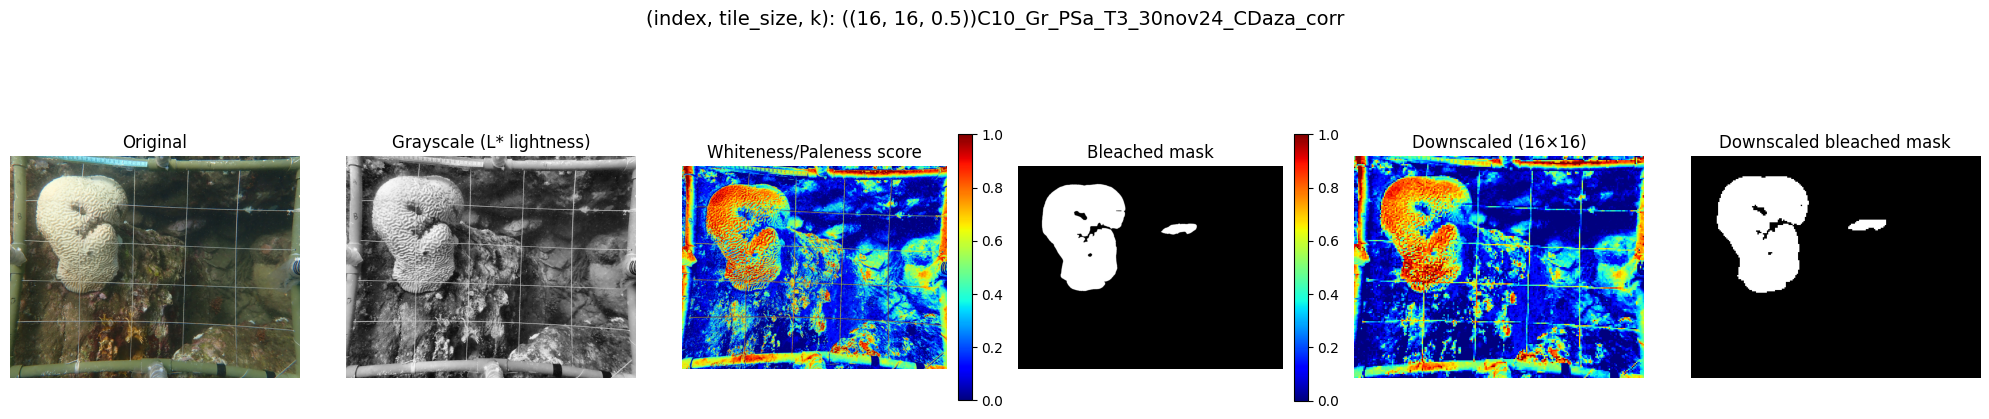

In [32]:
# Include bleached mask
# Add functionality to input idx or name

def demo_interpretability(idx: Union[int, None]=None, 
                          name: Union[str, None]=None, 
                          tile_size: int=16, 
                          k: float=0.6
                          ) -> None:
    """
    Showcases the whiteness score on images. 
    The first if else statement makes sure that either name or index is defined in the input.

    Args:
        idx (Union[int, None], optional): Index of the image. Defaults to None.
        name (Union[str, None], optional): Filename of the image. Defaults to None.
        tile_size (int, optional): Size of the tiles. Defaults to 16.
        k (float, optional): Weight of colorfulness. Defaults to 0.6.

    Raises:
        ValueError: Checks that the input has an index or filename.
    """
    # Define the index variable based on input
    if name is not None: 
        # Find first triple where the stem matches
        idx = next(i for i, (img_path, _, _) in enumerate(triple) if Path(img_path).stem == name)
    elif idx is None:
        raise ValueError("You must provide either idx or name")
    
    # Get the images based on the index
    img_path, mb_path, mu_path = triple[idx]
    img_bgr = cv2.imread(str(img_path))
    HEIGHT, WEIGHTS = img_bgr.shape[:2] # type: ignore

    # Load the bleached and unbleached masks
    mask_bleached = load_mask(mb_path, (HEIGHT, WEIGHTS))  
    mask_non_bleached = load_mask(mu_path, (HEIGHT, WEIGHTS))
    # Creates a mask of all coral (so union(bleached,unbleached))  
    all_coral_mask = (mask_bleached | mask_non_bleached) if (mask_bleached is not None and mask_non_bleached is not None) else None

    # Create the LAB image
    lab = bgr_to_lab(img_bgr)
    L, _, _ = cv2.split(lab)

    # Compute the whiteness score for the original image
    score = whiteness_paleness_score(img_bgr, valid_mask=all_coral_mask, k=k)

    # Create the downscaled image and masks
    img_bgr_downscaled = downscale_image(img_bgr, tile_size)
    mask_bleached_downscaled = downscale_mask(mask_bleached, tile_size)
    mask_non_bleached_downscaled = downscale_mask(mask_non_bleached, tile_size)
    # Creates a mask of all coral (so union(bleached,unbleached))  
    all_coral_mask_downscaled = (mask_bleached_downscaled | mask_non_bleached_downscaled) if (mask_bleached_downscaled is not None and mask_non_bleached_downscaled is not None) else None

    # Compute whiteness score for the downscaled image
    score_downscaled = whiteness_paleness_score(img_bgr_downscaled, valid_mask=all_coral_mask_downscaled, k=k)

    # Plotting
    fig, axs = plt.subplots(1, 6, figsize=(20, 5))

    # Original image
    axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")

    # LAB of original image
    axs[1].imshow(L, cmap="gray", vmin=0, vmax=255)
    axs[1].set_title("Grayscale (L* lightness)")
    axs[1].axis("off")

    # Whiteness of original image
    im2 = axs[2].imshow(score, cmap="jet", vmin=0, vmax=1)
    axs[2].set_title("Whiteness/Paleness score")
    axs[2].axis("off")
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    # Bleached mask of original
    if mask_bleached is not None:
        axs[3].imshow(mask_bleached, cmap="gray", vmin=0, vmax=1)
        axs[3].set_title("Bleached mask")
    else:
        axs[3].text(0.5, 0.5, "No mask", ha="center", va="center")
        axs[3].set_title("Bleached mask (missing)")
    axs[3].axis("off")

    # Whiteness of downscaled image
    im4 = axs[4].imshow(score_downscaled, cmap="jet", vmin=0, vmax=1)
    axs[4].set_title(f"Downscaled ({tile_size}×{tile_size})")
    axs[4].axis("off")
    plt.colorbar(im4, ax=axs[3], fraction=0.046, pad=0.04)

    if mask_bleached_downscaled is not None:
        axs[5].imshow(mask_bleached_downscaled, cmap="gray", vmin=0, vmax=1)
        axs[5].set_title("Downscaled bleached mask")
    else:
        axs[5].text(0.5, 0.5, "No mask", ha="center", va="center")
        axs[5].set_title("Downscaled bleached mask (missing)")
    axs[5].axis("off")

    plt.suptitle(f"(index, tile_size, k): ({idx, tile_size, k}){img_path.stem}", fontsize=14)
    plt.tight_layout()
    plt.show()
demo_interpretability(name = "C10_Gr_PSa_T3_30nov24_CDaza_corr", tile_size=16, k=0.5)